In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [28]:


#
# ==================================================================
#

def weight_variable(shape):
  initial = tf.truncated_normal( shape, stddev=0.1 )
  return tf.Variable( initial )

def bias_variable(shape):
  initial = tf.constant( 0.1, shape=shape )
  return tf.Variable(initial)

#
# ==================================================================
#

# Declare computation graph

y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )
p = tf.placeholder( tf.float32, name="p")
test_run = tf.placeholder( tf.bool, name="test_run")


W1 = weight_variable([784, 500])
b1 = bias_variable([500])
h1 = tf.nn.relu( tf.matmul( x, W1 ) + b1 )



#  dropout 1
h1 = tf.cond(test_run, lambda: tf.mul(h1, p),
             lambda: tf.mul(tf.to_float(tf.less(tf.random_uniform(tf.shape(h1)), p)), h1))




W2 = weight_variable([500, 500])
b2 = bias_variable([500])
h2 = tf.nn.relu( tf.matmul( h1, W2 ) + b2 )



#  dropout 2
h2 = tf.cond(test_run, lambda: tf.mul(h2, p),
             lambda: tf.mul(tf.to_float(tf.less(tf.random_uniform(tf.shape(h2)), p)), h2))




W3 = weight_variable([500, 1000])
b3 = bias_variable([1000])
h3 = tf.nn.relu( tf.matmul( h2, W3 ) + b3 )



#  dropout 3
h3 = tf.cond(test_run, lambda: tf.mul(h3, p),
             lambda: tf.mul(tf.to_float(tf.less(tf.random_uniform(tf.shape(h3)), p)), h3))




W4 = weight_variable([1000, 10])
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#
# ==================================================================
#

sess = tf.Session()
sess.run( tf.initialize_all_variables() )







#
# ==================================================================
#

# NOTE: we're using a single, fixed batch of the first 1000 images
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]
drop_probs = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]


test_accuracies = []
training_accuracies = []

for i in range(len(drop_probs)):
        
        sess.run( tf.initialize_all_variables() )
    
        drop_prob = drop_probs[i]
        
        
        acc = 0.0
        for i in range( 150 ):
          _, acc = sess.run( [ train_step, accuracy ], feed_dict={ x: images, y_: labels, p: drop_prob,
                                                                 test_run: False} )
        #   print( "step %d, training accuracy %g" % (i, acc) )
        training_accuracies.append(acc)

        #  if i%10==0:
        #      tmp = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels } )
        #      print( "          test accuracy %g" % tmp )

        #
        # ==================================================================
        #

        final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, p: drop_prob,
                                                  test_run: True} )
#         print( "test accuracy %g" % final_acc )
        test_accuracies.append(final_acc)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Baseline Acc = 0.8411

In [29]:
{"drop": drop_probs, "test": test_accuracies, "train": training_accuracies, 
 "baseline": [0.84] * len(drop_probs)}

{'baseline': [0.84, 0.84, 0.84, 0.84, 0.84, 0.84],
 'drop': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
 'test': [0.101, 0.14639999, 0.5625999, 0.81170011, 0.86900008, 0.84530008],
 'train': [0.11499999,
  0.12100001,
  0.25299999,
  0.67899996,
  0.88000005,
  1.0000001]}

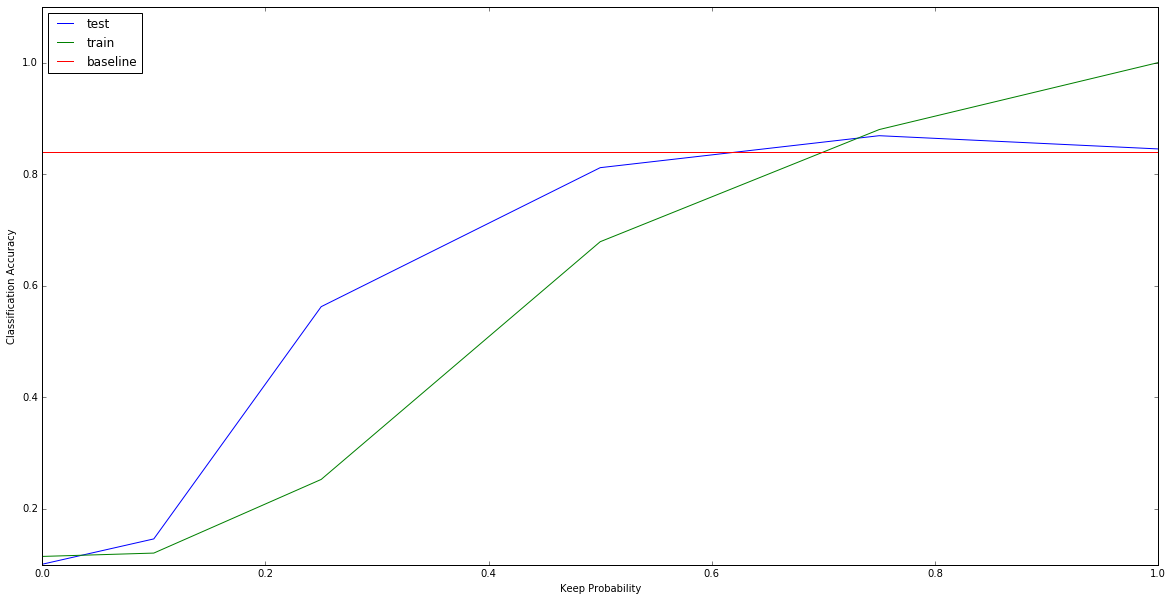

In [30]:
pd.DataFrame({"drop": drop_probs, "test": test_accuracies, "train": training_accuracies,
             "baseline": [0.84] * len(drop_probs)})\
                .plot(x="drop", y=["test","train", "baseline"], figsize=(20,10))
plt.xlabel("Keep Probability")
plt.ylabel("Classification Accuracy")